<a href="https://colab.research.google.com/github/Brandon-lz/master/blob/main/aicodes/14%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/ResNet%E7%9A%84%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

首先我们了解batch normalization：

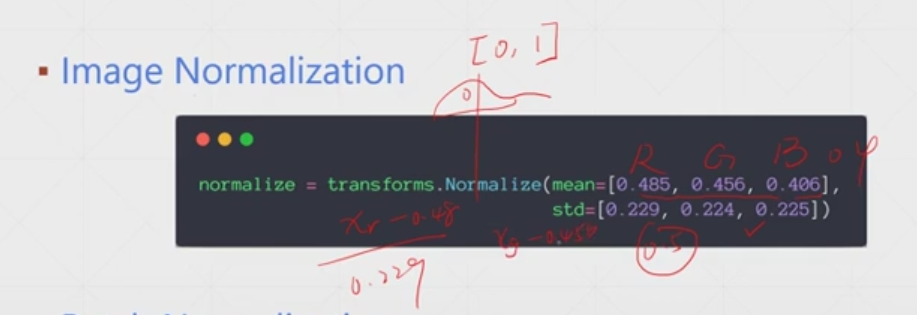

将图片数据进行标准化，使数据大致符合正态分布N（0,1）

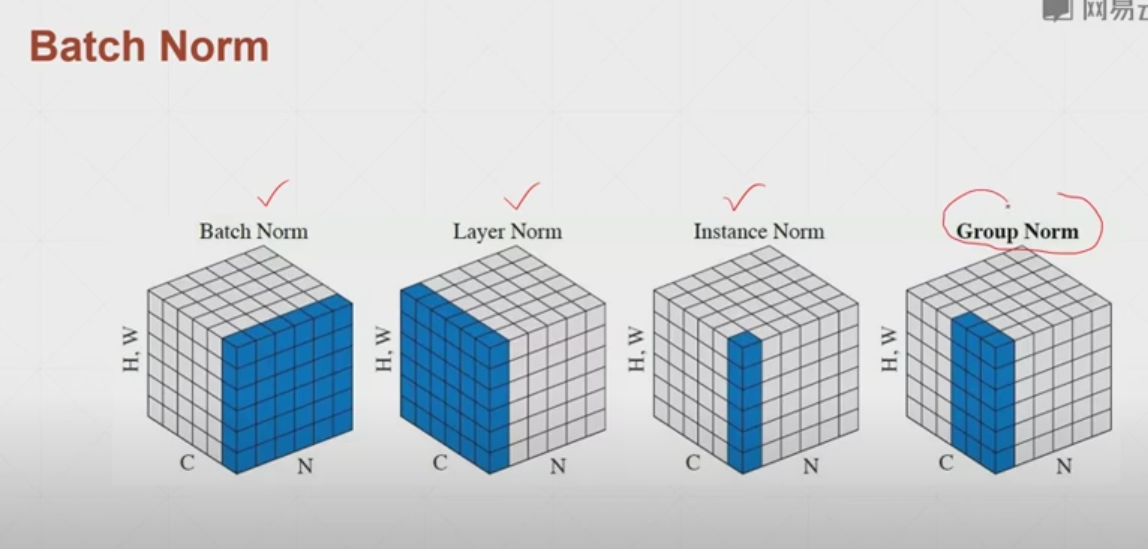

实际上有好几种normalization的方法，这里只介绍对通道进行统计的batch norm

batch normalization的计算步骤：   最后一步是缩放，将第三步得到的正态分布位移、缩放到合适的分布

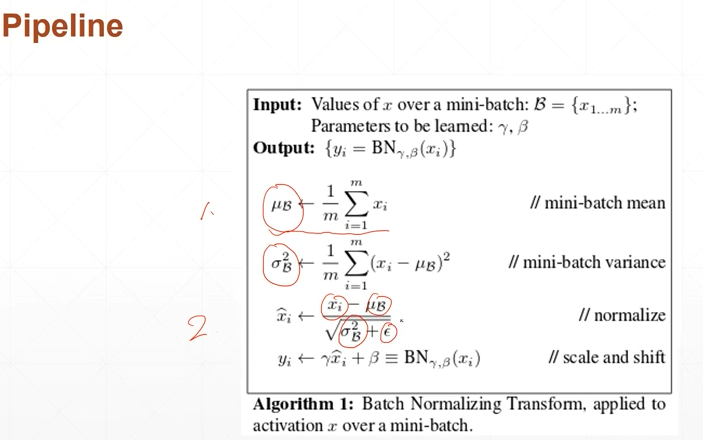

下面是使用batch normalization的好处：

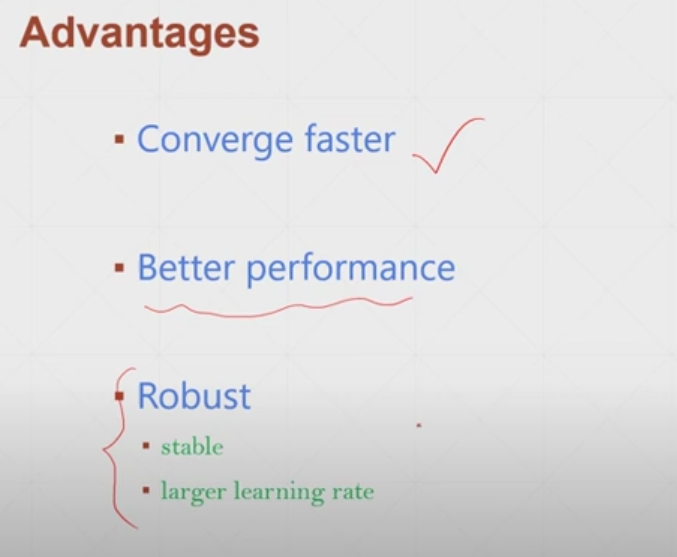

## 然后我们需要建立一个单元结构：Basic Block

它是由两个神经网络层、激活函数以及“短接线”x组成，x将它跨过的几层学习后的结果与之前输入的数据进行加和，这是resnet的核心原理

下图是resnet单元结构图，需要注意的是，短接线两端的数据结构必须一致，这样才能进行比较。而为了减少参数量，一般中间的层可以将参数进行压缩。

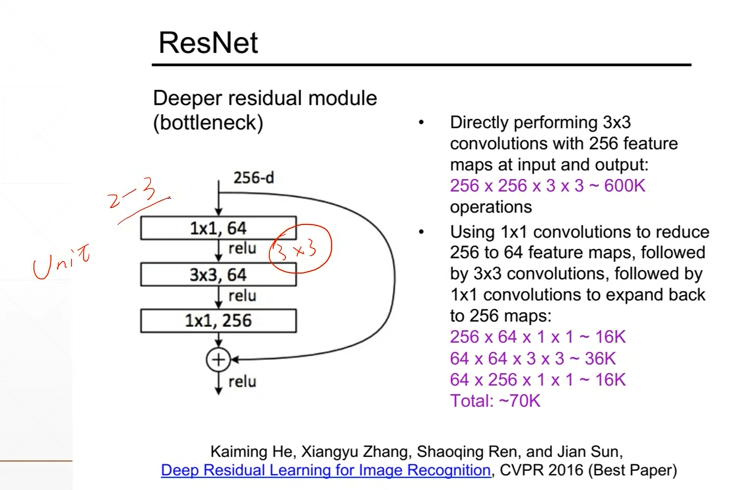

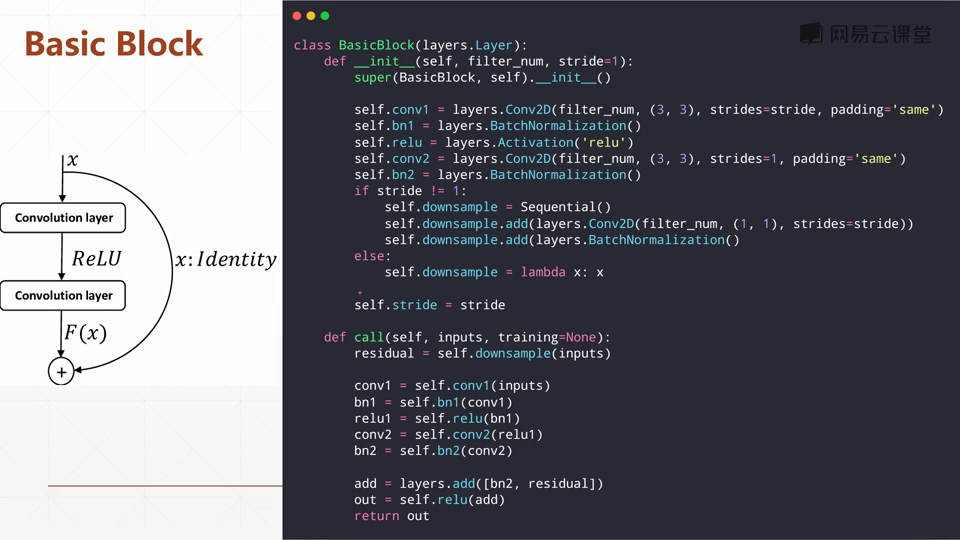

ResBlock:   由多个basic block组成的单元结构

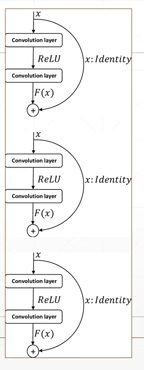

### 接下来进行resnet的实现：

In [ ]:
import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers, Sequential

In [ ]:
#实现上图的单元结构basic block
class BasicBlock(layers.Layer):
  def __init__(self,channel_num,stride=1):        #channel_num:输入输出的通道数量，一般交filter_num
    super(BasicBlock,self).__init__()

    #第一层
    self.conv1 = layers.Conv2D(channel_num,(3,3),strides=stride,padding='same')
    self.bn1 = layers.BatchNormalization()                #batch normalization层
    self.relu = layers.Activation('relu')                 #激活函数

    #第二层
    self.conv2 = layers.Conv2D(channel_num,(3,3),strides=1,padding='same')
    self.bn2 = layers.BatchNormalization()

    #第三层，短接线
    if stride != 1:
      self.downsample = Sequential()
      self.downsample.add(layers.Conv2D(channel_num,(1,1),strides=stride))    #添加下采样层，将输入数据与输出数据格式统一
    else:
      self.downsample = lambda x:x
   

  def call(self,inputs,training=None):          #重写该函数，这里可以自定义计算过程       

    out = self.conv1(inputs)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    identity = self.downsample(inputs)

    output = layers.add([out,identity])       #将学习后的结果out与输入数据进行加和
    output = tf.nn.relu(output)

    return output

In [ ]:
#实现Res Block
class ResNet(keras.Model):
  def __init__(self,layer_dims:list,num_classes=100):  #layer_dims=[2,2,2,2] ,代表了basicblock拥有的层数；  num_classes有多少个分类
    super(ResNet,self).__init__()

    #初始层
    self.stem = Sequential([layers.Conv2D(64,(3,3),strides=(1,1)),        #strides可分别定义在高和宽上的步长，这里等同于1
                 layers.BatchNormalization(),
                 layers.Activation('relu'),
                 layers.MaxPool2D(pool_size=(2,2),strides=(1,1),padding='same')           
                            ])
    self.layer1 = self.build_resblock(64,layer_dims[0])
    self.layer2 = self.build_resblock(128,layer_dims[1],stride=2)
    self.layer3 = self.build_resblock(256,layer_dims[2],stride=2)
    self.layer4 = self.build_resblock(512,layer_dims[3],stride=2)     #这是一个通道数增加，维度减少的过程

    #output [b,h,w,512]
    self.avgpool = layers.GlobalAveragePooling2D()      #将长宽数据消除全部求平均数[b,h,w,512] =>[b,512]
    self.fc = layers.Dense(num_classes)           #全连接层，最终得到100个分类


  def call(self,inputs,training=None):
    
    x = self.stem(inputs)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)   #[b,512]
    x = self.fc(x)

    return x

  
  def build_resblock(self,channel_num,basicblocks_num,stride=1):
    
    res_blocks = Sequential()
    #may down sample
    res_blocks.add(BasicBlock(channel_num,stride))   #添加第一个basicblock，

    for _ in range(1,basicblocks_num):
      res_blocks.add(BasicBlock(channel_num,stride=1))    #添加后续的basicblock

    return res_blocks

In [ ]:
def resnet18():
  return ResNet([2,2,2,2])


def resnet34():     
  return ResNet([3,4,6,3])    #每个basic block含有两个卷积层，算下来一共32层，加上第一层和最后全连接层共34层

上面完成了resnet的准备工作，接下来开始使用resnet训练cifar100数据集，训练过程与之前一样，只是模型变了

In [ ]:
import  tensorflow as tf
from    tensorflow.keras import layers, optimizers, datasets, Sequential
import  os


os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
tf.random.set_seed(2345)





def preprocess(x, y):
  # [-1~1]
  x = tf.cast(x, dtype=tf.float32) / 255. - 0.5
  y = tf.cast(y, dtype=tf.int32)
  return x,y


(x,y), (x_test, y_test) = datasets.cifar100.load_data()
y = tf.squeeze(y, axis=1)
y_test = tf.squeeze(y_test, axis=1)
print(x.shape, y.shape, x_test.shape, y_test.shape)


train_db = tf.data.Dataset.from_tensor_slices((x,y))
train_db = train_db.shuffle(1000).map(preprocess).batch(512)

test_db = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_db = test_db.map(preprocess).batch(512)

sample = next(iter(train_db))
print('sample:', sample[0].shape, sample[1].shape,
      tf.reduce_min(sample[0]), tf.reduce_max(sample[0]))


def main():

  # [b, 32, 32, 3] => [b, 1, 1, 512]
  model = resnet18()
  model.build(input_shape=(None, 32, 32, 3))
  model.summary()
  optimizer = optimizers.Adam(lr=1e-3)

  for epoch in range(500):

    for step, (x,y) in enumerate(train_db):

      with tf.GradientTape() as tape:
        # [b, 32, 32, 3] => [b, 100]
        logits = model(x)
        # [b] => [b, 100]
        y_onehot = tf.one_hot(y, depth=100)
        # compute loss
        loss = tf.losses.categorical_crossentropy(y_onehot, logits, from_logits=True)
        loss = tf.reduce_mean(loss)

      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      if step %50 == 0:
        print(epoch, step, 'loss:', float(loss))



    total_num = 0
    total_correct = 0
    for x,y in test_db:

      logits = model(x)
      prob = tf.nn.softmax(logits, axis=1)
      pred = tf.argmax(prob, axis=1)
      pred = tf.cast(pred, dtype=tf.int32)

      correct = tf.cast(tf.equal(pred, y), dtype=tf.int32)
      correct = tf.reduce_sum(correct)

      total_num += x.shape[0]
      total_correct += int(correct)

    acc = total_correct / total_num
    print(epoch, 'acc:', acc)



if __name__ == '__main__':

  main()


169009152/169001437 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)
sample: (512, 32, 32, 3) (512,) tf.Tensor(-0.5, shape=(), dtype=float32) tf.Tensor(0.5, shape=(), dtype=float32)
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 30, 30, 64)        2048      
_________________________________________________________________
sequential_1 (Sequential)    (None, 30, 30, 64)        148736    
_________________________________________________________________
sequential_2 (Sequential)    (None, 15, 15, 128)       526976    
_________________________________________________________________
sequential_4 (Sequential)    (None, 8, 8, 256)         2102528   
_________________________________________________________________
sequential_6 (Sequential)    (None, 4, 4, 512)         8399360   
_____________________